In [6]:
import yfinance as yf 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.optimizers import Adam
from math import sqrt

In [7]:
#Defining the list of stock tickers
tickers = ["AMZN", "AAPL", "MSFT", "META", "GOOGL"]

#Definng the start and end dates
start_date = dt.datetime.now() - dt.timedelta(days = 6*365)
end_date = dt.datetime.now()

#Here we will fetch the data from yfinance and store it in a dictionary

stock_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start = start_date, end = end_date).dropna()

#Concatenate the stock data obtained into one dataframe
data = pd.concat(stock_data.values(), axis =1, keys= stock_data.keys())

data.index = pd.to_datetime(data.index)
print(data.head())
data.describe()

                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-03-17 00:00:00-04:00  42.674500  42.691502  42.532001  42.615501   
2017-03-20 00:00:00-04:00  42.575500  42.889999  42.550499  42.848499   
2017-03-21 00:00:00-04:00  42.942001  43.139999  42.065498  42.160000   
2017-03-22 00:00:00-04:00  42.021500  42.468498  41.952499  42.403000   
2017-03-23 00:00:00-04:00  42.410000  42.544498  42.240002  42.368999   

                                                                 AAPL  \
                             Volume Dividends Stock Splits       Open   
Date                                                                    
2017-03-17 00:00:00-04:00  67688000       0.0          0.0  33.081232   
2017-03-20 00:00:00-04:00  45654000       0.0          0.0  32.940461   
2017-03-21 00:00:00-04:00  87658000       0.0     

AMZN                                                       \
              Open         High          Low        Close        Volume   
count  1509.000000  1509.000000  1509.000000  1509.000000  1.509000e+03   
mean    109.853183   111.153804   108.405986   109.793623  8.400965e+07   
std      40.331768    40.830108    39.777855    40.269469  3.991550e+07   
min      41.903500    42.468498    41.674999    42.160000  1.762600e+07   
25%      83.234497    84.174004    81.855499    83.177002  5.748600e+07   
50%      96.315498    97.248001    95.015503    96.050003  7.239710e+07   
75%     154.913498   156.644501   151.856995   154.474503  9.872800e+07   
max     187.199997   188.654007   184.839493   186.570496  3.313000e+08   

                                     AAPL                            ...  \
      Dividends Stock Splits         Open         High          Low  ...   
count    1509.0  1509.000000  1509.000000  1509.000000  1509.000000  ...   
mean        0.0     0.013254    90.251710    91.329629    89.229297  ...   
std         0.0     0.514856    48.201170    48.852241    47.569764  ...   
min         0.0     0.000000    32.703498    33.081232    32.522841  ...   
25%         0.0     0.000000    44.323321    44.627169    43.911808  ...   
50%         0.0     0.000000    72.669286    74.158076    72.179903  ...   
75%         0.0     0.000000   139.973740   141.671913   137.561411  ...   
max         0.0    20.000000   181.299361   181.607100   177.814925  ...   

               META                               GOOGL               \
             Volume Dividends Stock Splits         Open         High   
count  1.509000e+03    1509.0       1509.0  1509.000000  1509.000000   
mean   2.341622e+07       0.0          0.0    81.010664    81.896998   
std    1.633181e+07       0.0          0.0    30.957387    31.302610   
min    6.046300e+06       0.0          0.0    41.404499    42.069000   
25%    1.439140e+07       0.0          0.0    55.625500    56.270000   
50%    1.924920e+07       0.0          0.0    68.065498    69.139000   
75%    2.729910e+07       0.0          0.0   103.988503   105.331001   
max    2.323166e+08       0.0          0.0   151.250000   151.546494   

                                                                      
               Low        Close        Volume Dividends Stock Splits  
count  1509.000000  1509.000000  1.509000e+03    1509.0  1509.000000  
mean     80.130944    81.033850  3.511511e+07       0.0     0.013254  
std      30.569338    30.930289  1.589364e+07       0.0     0.514856  
min      41.215000    41.757000  9.312000e+06       0.0     0.000000  
25%      55.000000    55.583500  2.515400e+07       0.0     0.000000  
50%      67.536499    68.433998  3.106000e+07       0.0     0.000000  
75%     102.833504   104.440498  4.000800e+07       0.0     0.000000  
max     148.899002   149.838501  1.331780e+08       0.0    20.000000  

[8 rows x 35 columns]

In [8]:
#Calculating the total values in the dataset
total = data.size
print(f'Total values- {total}')

#Check for null values in the dataset
null= data.isnull() 
total_null = null.sum().sum()
print(f'total number of null values : {total_null}')

#to veiw the whole datset we will covert the obtained data into a csv file 
data.to_csv("combinedData.csv")


Total values- 52815
total number of null values : 0


We can see from the above output that the total number of null values in our dataset is zero, meaning we can now procees to the next step - analysis of our data and adding technical indicators for better analysis

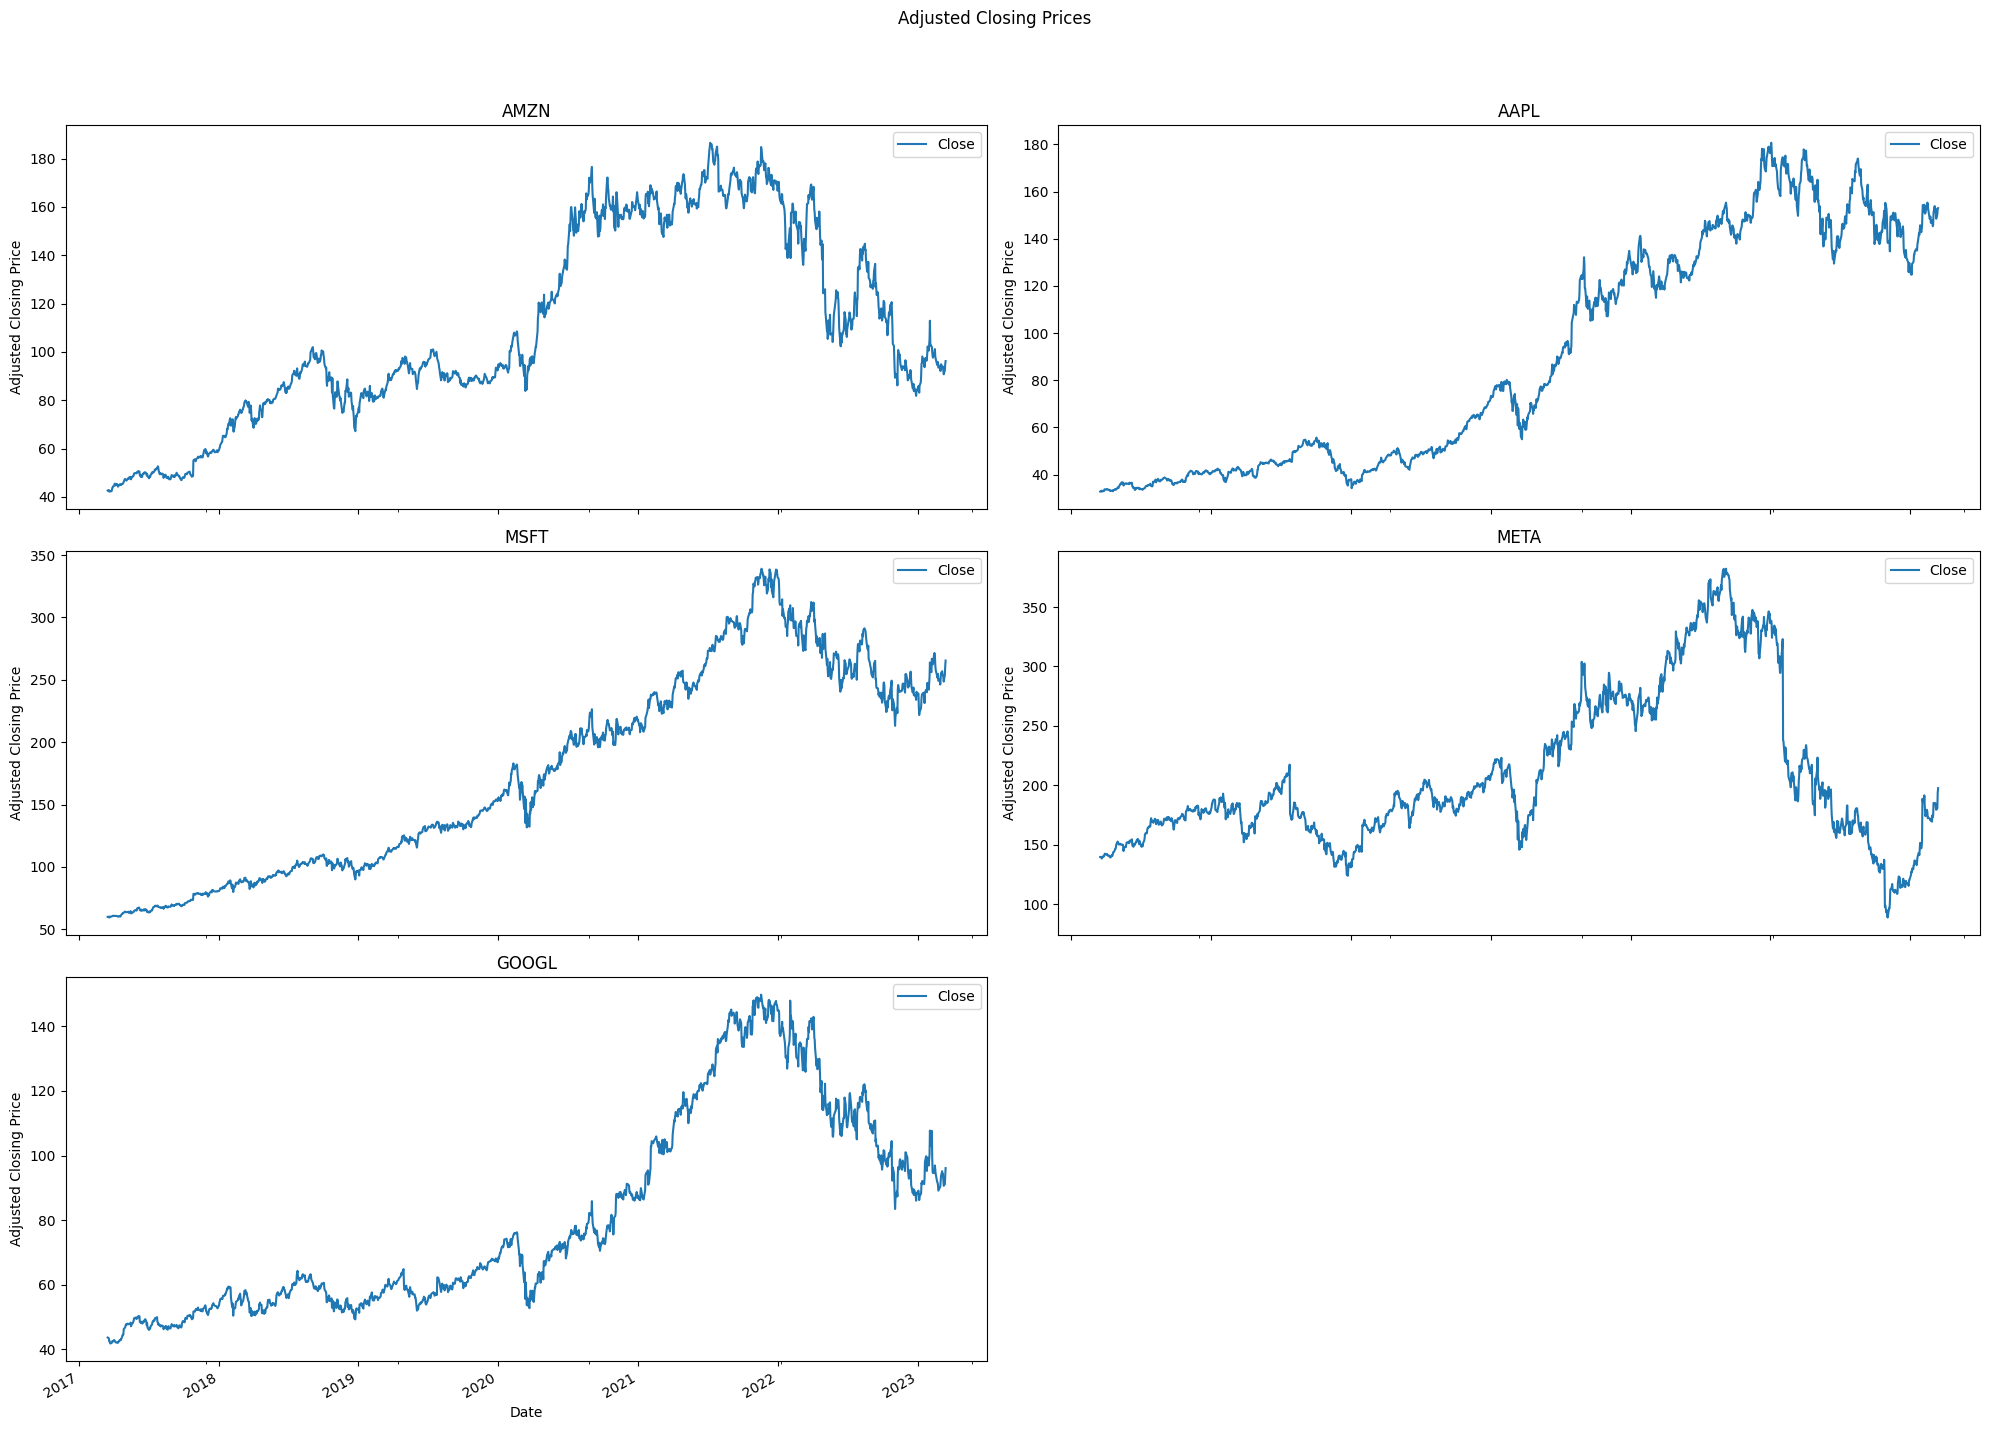

In [9]:
#Here we will plot the Closing prices for each company to see there trends over the last 6 years

AdjClose = data.loc[:,(slice(None), 'Close')] # Extracting adj close prices
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Adjusted Closing Prices')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    AdjClose[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Adjusted Closing Price')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

 

Observations from the above graphs obtained:
1. The adjusted closing prices for each company have increased over time especially between the time period 2020-2021 (Covid 19)
2. We can see a sudden downtrend between the time period 2022-2023 for META.
3. Google has generally had the highest adjusted closing prices among the five companies, while Meta (formerly Facebook) has generally had the lowest.
4. Apple's adjusted closing prices appear to be the most volatile, with more frequent spikes and dips compared to the other companies.
5. (Inflection Points) There are some periods of time where the adjusted closing prices for all five companies move in the same direction, such as during market-wide trends or events (for example during covid-19). Conversely, there may be other periods where the companies' prices move in opposite directions or have different levels of volatility.

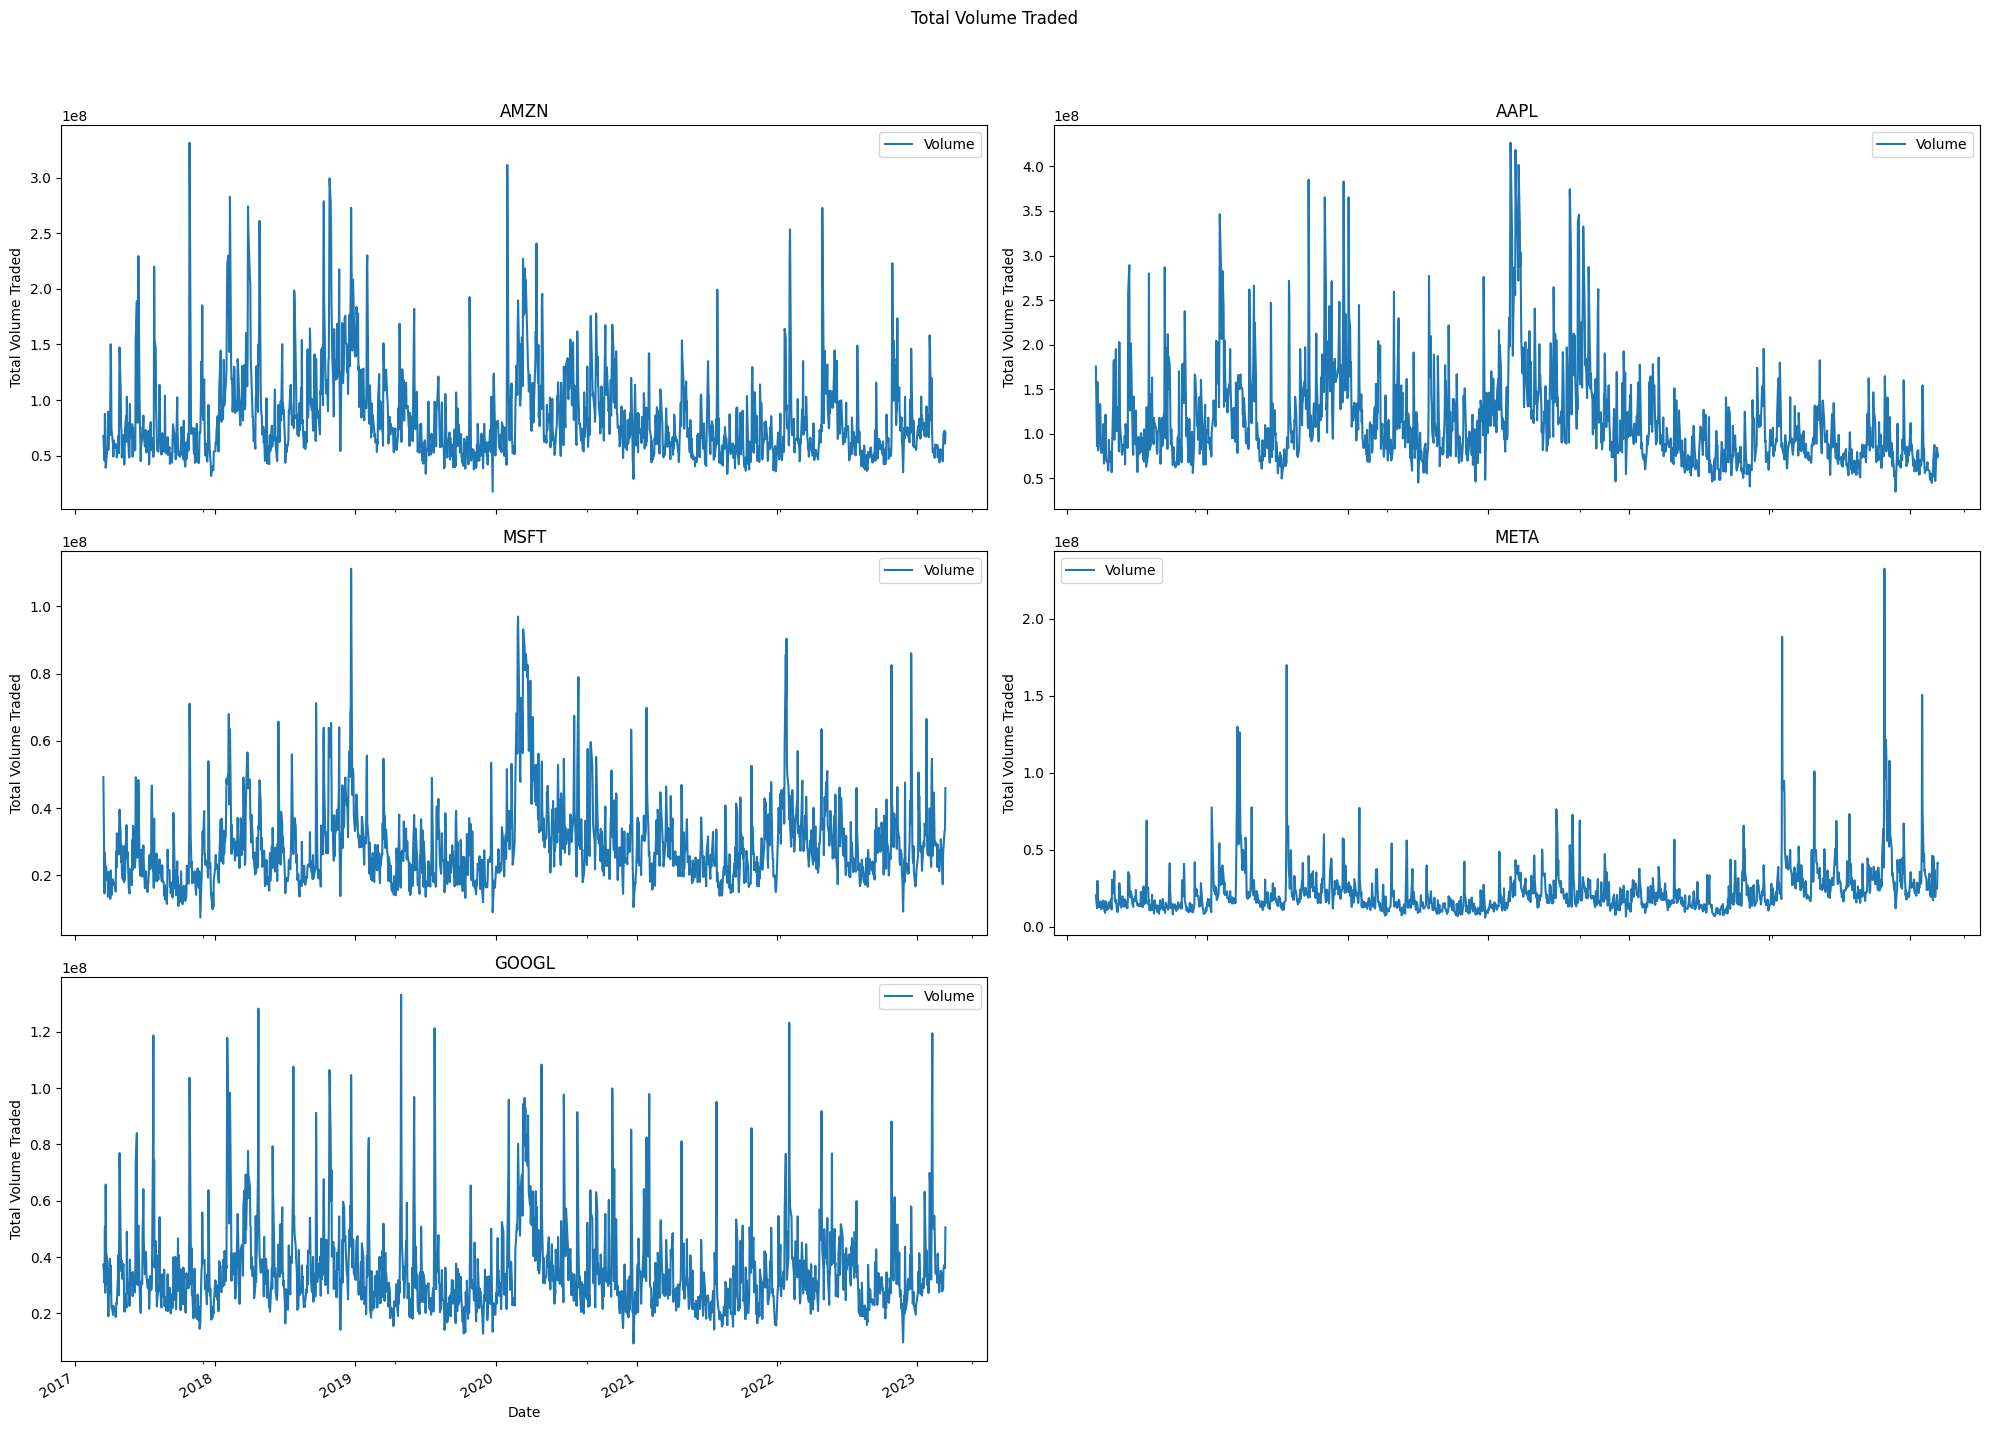

In [10]:
#If we want to analyse the total volume of the stock traded we can do that by plotting it 

VolTraded = data.loc[:,(slice(None), 'Volume')]
numrows = len(tickers) // 2 + len(tickers) % 2 # defining number of rows and columns for the subplots
numcols = 2

fig, axs = plt.subplots(nrows= numrows, ncols = numcols, figsize = (20,15), sharex = True)
fig.suptitle('Total Volume Traded')

axs_flat = axs.flatten() #this will convert 2d axes array to 1d for easier iteration over the axes

for i, ticker in enumerate(tickers):
    VolTraded[ticker].plot(ax=axs_flat[i], title = ticker)
    axs_flat[i].set_xlabel('Date')
    axs_flat[i].set_ylabel('Total Volume Traded')

# Remove the extra unused subplot
fig.delaxes(axs_flat[-1])

#layout spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. The above plots shows us the total volume traded for company over a specific date range.
2. The sudden spikes and drops in the above plots shows the important market events that impacted the comapnies correspondingly.
3. We can compare the relative liquidity of each stock, the higher average trading volumes are considered more liquid indicating that it is much easier to sell or buy the shares without having an impact on the stock price.

Calculating Moving Average of the Adjusted Closing Prices for the companies 

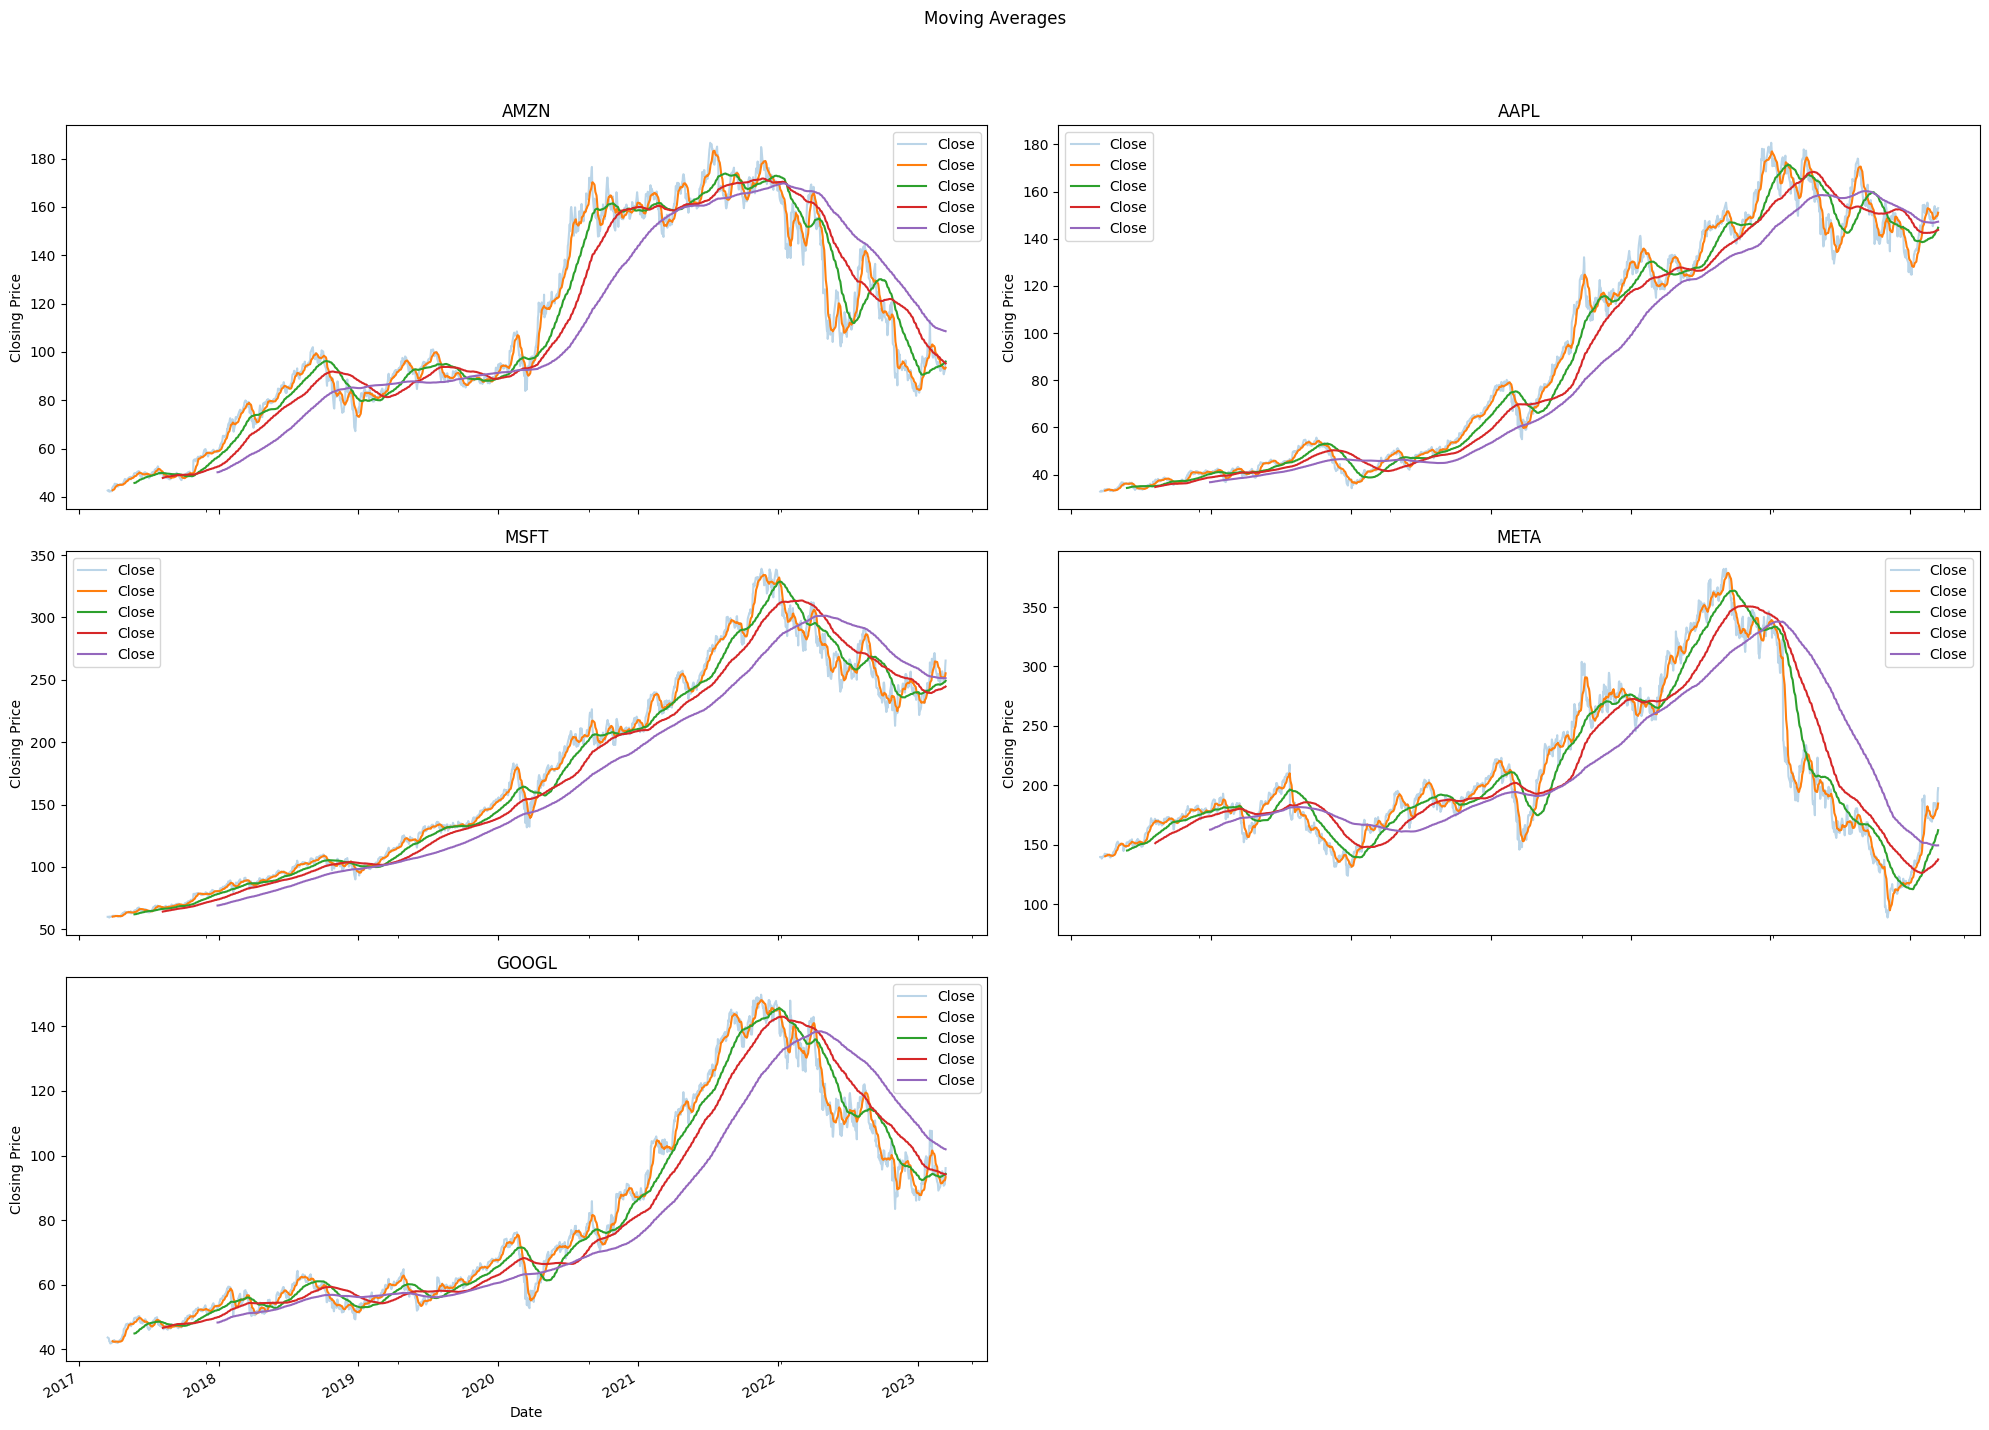

In [11]:
import matplotlib.pyplot as plt

# Calculate the moving averages of the Closing price
MA = [10, 50, 100, 200]
AdjClose = data.loc[:, (slice(None), 'Close')]

# Define the number of rows and columns for the subplots
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows, ncols=numcols, figsize=(20, 15), sharex=True)
fig.suptitle('Moving Averages')

# Loop through each ticker
for i, ticker in enumerate(tickers):
    ax = axs[i // numcols, i % numcols]
    
    # Plot the original closing prices
    AdjClose[ticker].plot(ax=ax, alpha=0.3, label='Closing Price')

    # Calculate and plot the moving averages
    for ma in MA:
        ma_series = AdjClose[ticker].rolling(window=ma).mean()
        ma_series.plot(ax=ax, label=f'MA {ma} days')

    ax.set_title(ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. Calculating moving average helps us to understand the overall trend of the stock price, rising moving average indicates an uptrend and vica versa
2. When a stock price is above the moving average it signifies that the stocks can be bought that is it acts as support level whereas if the stock price approaches from below it indicates resistance from the moving average.

Calculating the RSI(Relative Strength Indicator) and Moving Average Convergence Divergence (MACD)

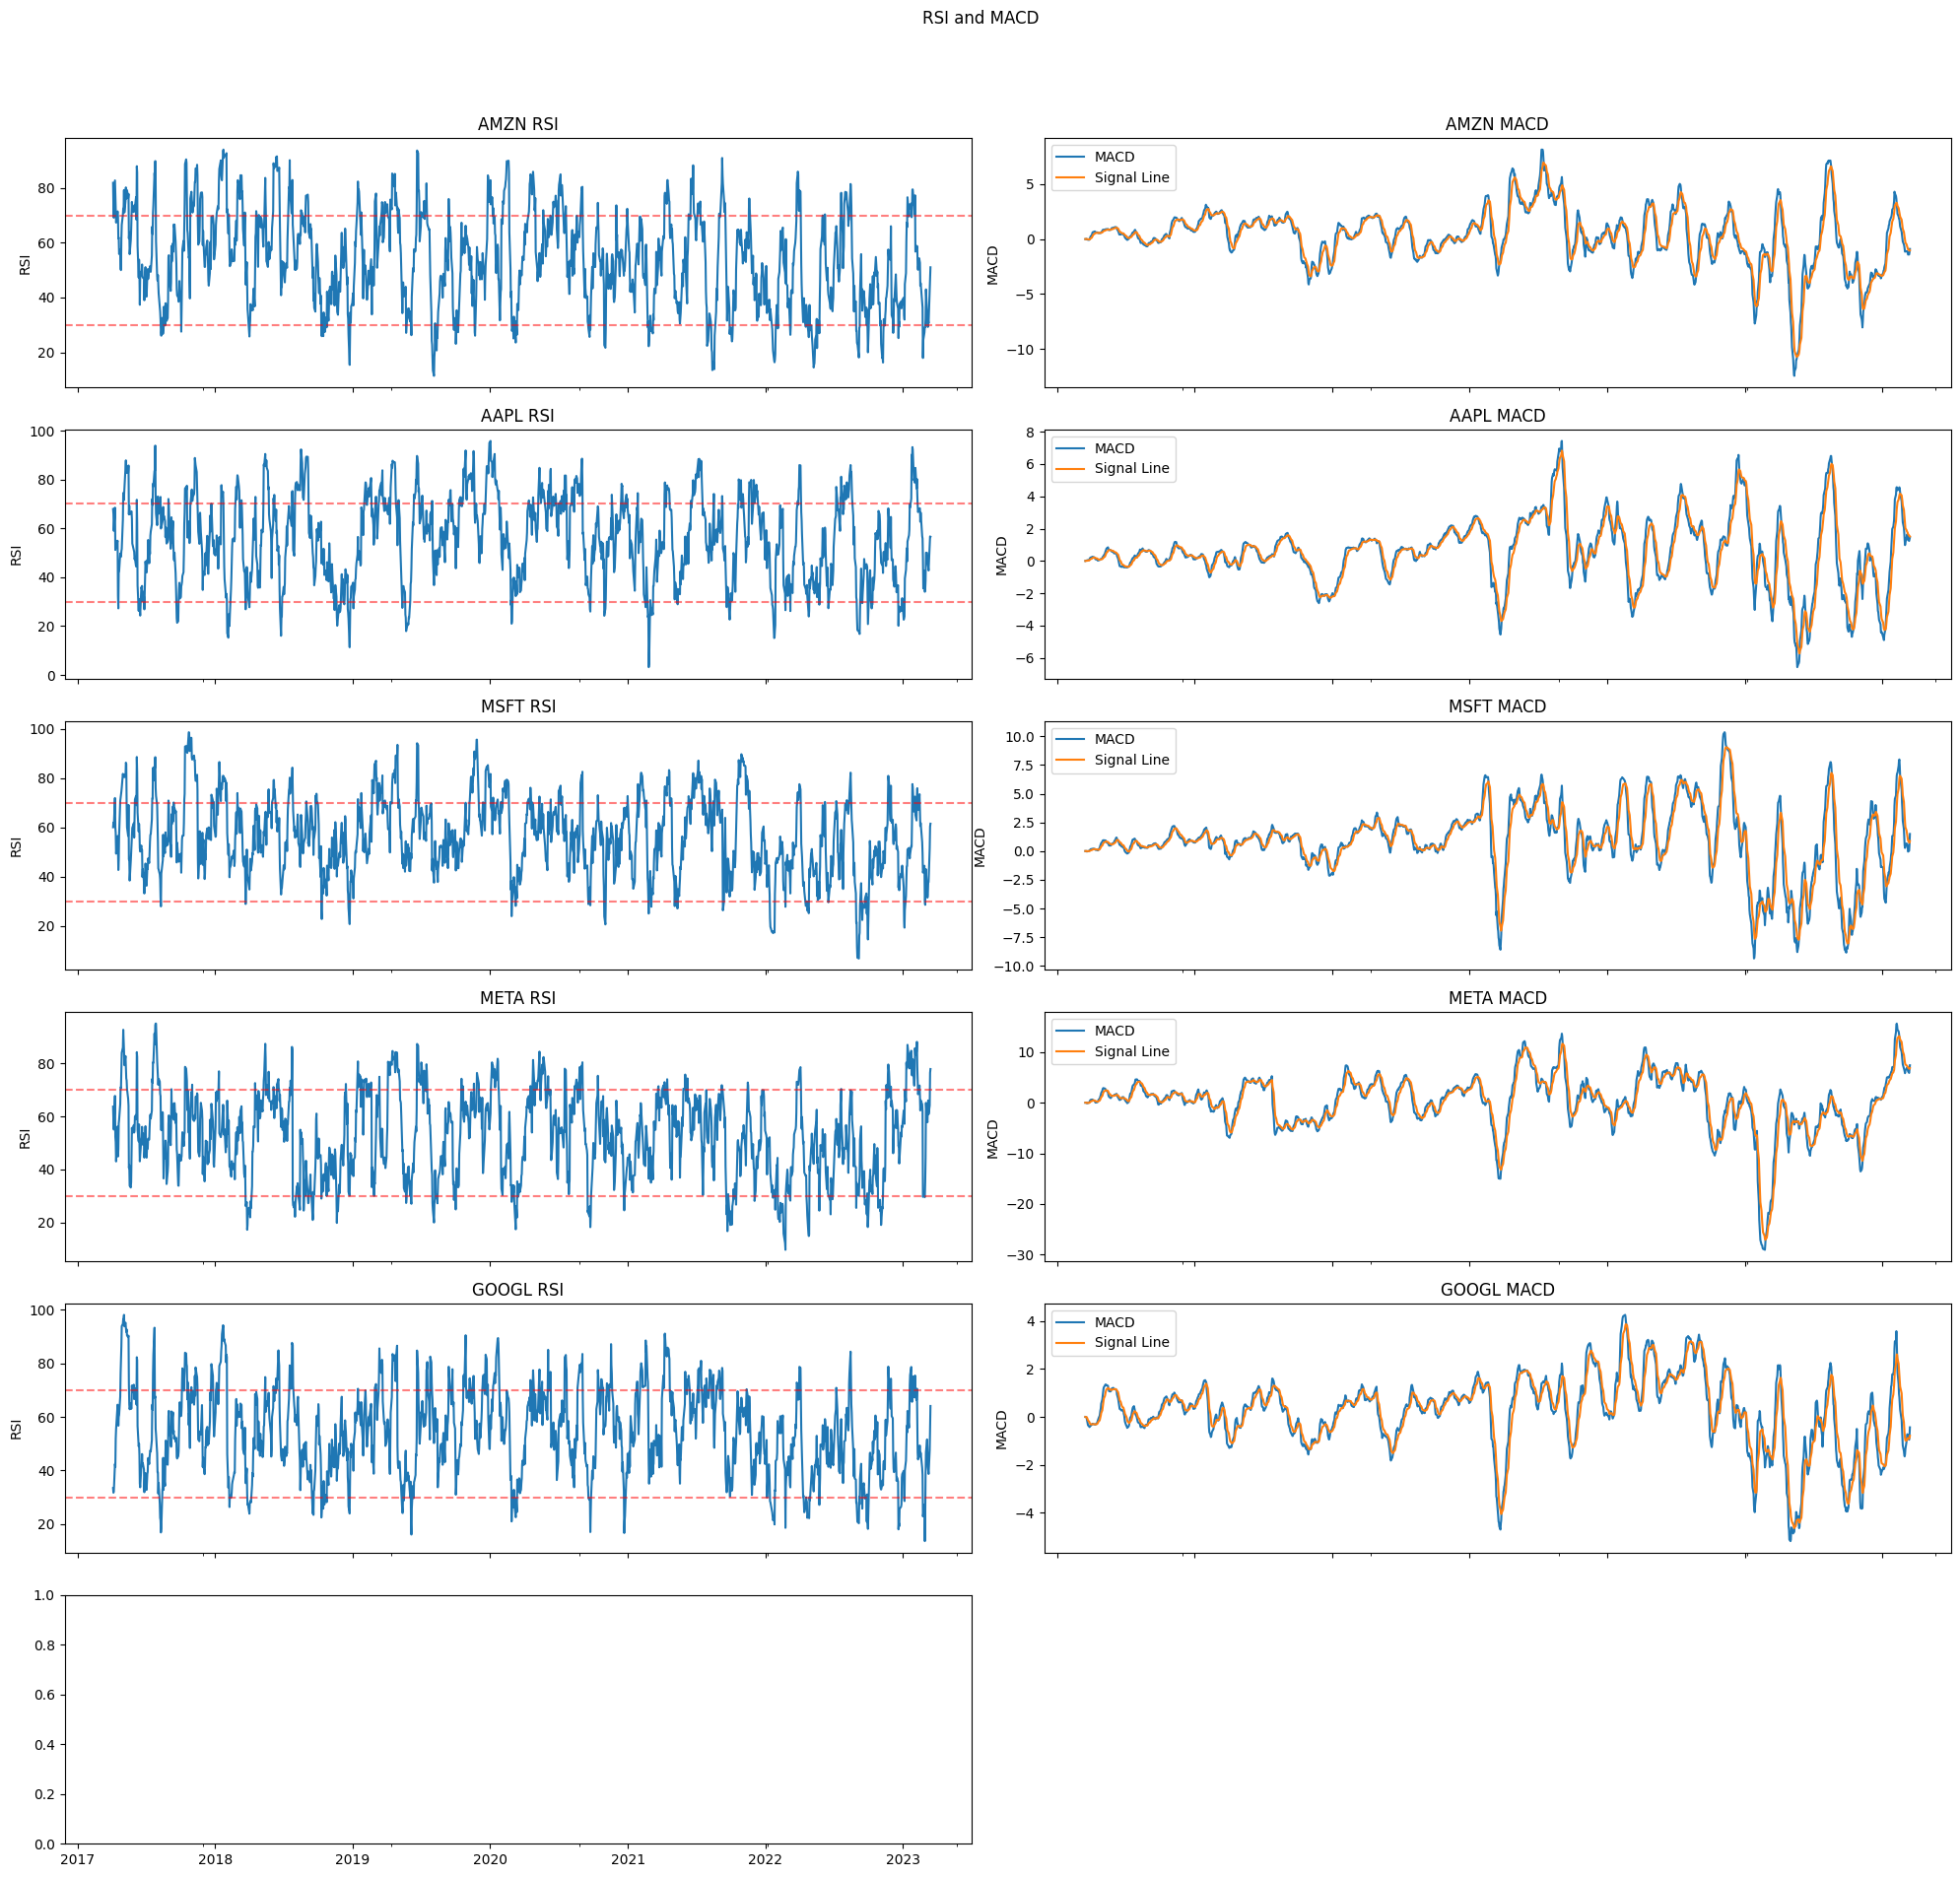

In [12]:
 # Calculate RSI
def rsi(data, period=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate MACD
def macd(data, short_period=12, long_period=26, signal_period=9):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Plot RSI and MACD for each company
numrows = len(tickers) // 2 + len(tickers) % 2
numcols = 2

fig, axs = plt.subplots(nrows=numrows*2, ncols=numcols, figsize=(20, 20), sharex=True)
fig.suptitle('RSI and MACD')
axs_flat = axs.flatten()

for i, ticker in enumerate(tickers):
    # RSI plot
    rsi_data = rsi(data[ticker])
    rsi_data.plot(ax=axs_flat[i*2], title=f'{ticker} RSI')
    axs_flat[i*2].axhline(30, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].axhline(70, color='red', linestyle='--', alpha=0.5)
    axs_flat[i*2].set_xlabel('Date')
    axs_flat[i*2].set_ylabel('RSI') 

# Remove the extra unused subplot
axs[-1, -1].axis('off')

for i, ticker in enumerate(tickers):
    # MACD plot
    macd_line, signal_line = macd(data[ticker])
    macd_line.plot(ax=axs_flat[i*2+1], title=f'{ticker} MACD', label='MACD')
    signal_line.plot(ax=axs_flat[i*2+1], label='Signal Line')
    axs_flat[i*2+1].set_xlabel('Date')
    axs_flat[i*2+1].set_ylabel('MACD')
    axs_flat[i*2+1].legend()

# Remove the extra unused subplot
axs[-1, -1].axis('off')

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Relative Strength Index-
1. It is a momentum indicator
2. Basic formula => RSI = 100 - (100 / (1 + RS)) where RS represents the average gain or average loss.
3. The above plot shows the Relative Strength Index for each company using the adjusted close price data. If the RSI value for a company is above 70- it indicated that it is a good time for selling stocks and below 30 indicated good time to consider for buying a stock.
4. From the MACD graphs, we can see the trend of each company's stock momentum, as well as the buy and sell signals that can be derived from the MACD Line and Signal Line crossovers. The MACD Histogram also provides an indication of the strength of the trend, with positive values indicating an uptrend and negative values indicating a downtrend.

Extracting the features from the above technical indicators to be used in our model

In [13]:
# Moving Average Crossover
short_term_ma = 50
long_term_ma = 100
AdjClose = data.loc[:, (slice(None), 'Close')]
short_term = AdjClose.rolling(window=short_term_ma).mean()
long_term = AdjClose.rolling(window=long_term_ma).mean()
moving_average_crossover = ( short_term >  long_term).astype(int)

# RSI Overbought/Oversold Indicator
rsi_threshold_overbought = 70
rsi_threshold_oversold = 30
rsi_data = {ticker: rsi(data[ticker]) for ticker in tickers}
rsi_features = {}
for ticker in tickers:
    rsi_features[ticker] = pd.cut(
        rsi_data[ticker],
        bins=[-np.inf, rsi_threshold_oversold, rsi_threshold_overbought, np.inf],
        labels=['oversold', 'neutral', 'overbought'],
    ) 

# MACD Crossover and Divergence
macd_data = {ticker: macd(data[ticker]) for ticker in tickers}
macd_crossover = {}
macd_divergence = {}
for ticker in tickers:
    macd_line, signal_line = macd_data[ticker]
    macd_crossover[ticker] = (macd_line > signal_line).astype(int)
    macd_divergence[ticker] = macd_line - signal_line


In [14]:
# Shift features by one period into the future
shifted_features = {}

# Moving Average Crossover
shifted_features['moving_average_crossover'] = moving_average_crossover.shift(1)

# RSI Overbought/Oversold Indicator
shifted_features['rsi'] = {}
for ticker in tickers:
    shifted_features['rsi'][ticker] = rsi_features[ticker].shift(1)

# MACD Crossover and Divergence
shifted_features['macd_crossover'] = {}
shifted_features['macd_divergence'] = {}
for ticker in tickers:
    shifted_features['macd_crossover'][ticker] = macd_crossover[ticker].shift(1)
    shifted_features['macd_divergence'][ticker] = macd_divergence[ticker].shift(1)

    

In [15]:
scaler = MinMaxScaler()
scaled_data = {}
for ticker in tickers:
    # Include all variables from companies dataset
    ticker_data = data.loc[:, (ticker, slice(None))].droplevel(0, axis=1)

    
    # Add new features
    ticker_data['Moving_Average_Crossover'] = shifted_features['moving_average_crossover'][ticker] 
    ticker_data['RSI'] = shifted_features['rsi'][ticker].replace({'oversold': 0, 'neutral': 1, 'overbought': 2}).astype(float)
    ticker_data['MACD_Crossover'] = shifted_features['macd_crossover'][ticker] 
    ticker_data['MACD_Divergence'] = shifted_features['macd_divergence'][ticker] 
    
    # Scale the data
    scaled_ticker_data = pd.DataFrame(scaler.fit_transform(ticker_data), columns=ticker_data.columns, index=ticker_data.index)
    
    # Save the scaled data in a dictionary
    scaled_data[ticker] = scaled_ticker_data


In [16]:
#Verifying the contents of the scaled dataset, checking all the column names and datatypes of each Dataframe
for ticker in tickers:
    print(f"{ticker} Scaled Data:")
    print(scaled_data[ticker].head())  # Adjust the number of rows displayed by changing the value within .head()
    print("\n")

for ticker in tickers:
    print(f"{ticker} Columns and Data Types:")
    print(scaled_data[ticker].dtypes)
    print("\n")

for ticker in tickers:
    scaled_ticker_data = scaled_data[ticker]
    file_name = f"{ticker}_scaled_data.csv"
    scaled_ticker_data.to_csv(file_name)



AMZN Scaled Data:
                               Open      High       Low     Close    Volume  \
Date                                                                          
2017-03-17 00:00:00-04:00  0.005306  0.001525  0.005986  0.003154  0.159599   
2017-03-20 00:00:00-04:00  0.004625  0.002883  0.006115  0.004768  0.089354   
2017-03-21 00:00:00-04:00  0.007147  0.004593  0.002728  0.000000  0.223264   
2017-03-22 00:00:00-04:00  0.000812  0.000000  0.001938  0.001683  0.113328   
2017-03-23 00:00:00-04:00  0.003486  0.000520  0.003947  0.001447  0.068332   

                           Dividends  Stock Splits  Moving_Average_Crossover  \
Date                                                                           
2017-03-17 00:00:00-04:00        0.0           0.0                       NaN   
2017-03-20 00:00:00-04:00        0.0           0.0                       0.0   
2017-03-21 00:00:00-04:00        0.0           0.0                       0.0   
2017-03-22 00:00:00-04:00   

Splitting the Dataset into Training(70%), Test(15%) and Validation Set(15%)

In [17]:
train_size = 0.7
test_size = 0.2
# Concatenate the data for all tickers into a single DataFrame
combined_data = pd.concat(scaled_data.values()).dropna()

# Separate the response variable "Open" and the predictors
X = combined_data.drop(columns=['Open'])
y = combined_data['Open']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

val_size = 0.1
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size), shuffle=False)

# Save the sets in the corresponding dictionaries
train_data = {'X': X_train, 'y': y_train}
test_data = {'X': X_test, 'y': y_test}
val_data = {'X': X_val, 'y': y_val}

# Print the data
print("Total training data points:", X_train.shape[0])
print("Total testing data points:", X_test.shape[0])
print("Total validation data points:", X_val.shape[0])



Total training data points: 5232
Total testing data points: 1495
Total validation data points: 748


Reshaping the Data

In [18]:
# Reshape the training data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train = y_train.values

# Reshape the testing data
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test = y_test.values

# Reshape the validation data
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
y_val = y_val.values


Removing all NaN values after preprocessing

In [19]:
for ticker in tickers:
    scaled_data[ticker] = scaled_data[ticker].fillna(scaled_data[ticker].mean())


In [20]:
for ticker, ticker_data in scaled_data.items():
    if ticker_data.isnull().any().any():
        print(f"NaN values found in {ticker}")


We can see there are no null values in out dataset, now we can proceed to build our model

In [21]:
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
def Model(input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.0005, regularization=L1L2(l1=0.01, l2=0.01)): 
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_train, y_train = create_sequences(train_data['X'], train_data['y'], time_steps)
X_val, y_val = create_sequences(val_data['X'], val_data['y'], time_steps)

# Train the model
input_shape = (time_steps, X_train.shape[2])
model = Model(input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
162/162 [==============================] - 11s 49ms/step - loss: 0.0172 - val_loss: 0.0051
Epoch 2/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 3/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 4/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 5/100
162/162 [==============================] - 7s 42ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 6/100
162/162 [==============================] - 6s 40ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 7/100
162/162 [==============================] - 6s 40ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 8/100
162/162 [==============================] - 7s 45ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 9/100
162/162 [==============================] - 6s 40ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 10/100
162/162 [==============================] - 7s 43ms/step - loss: 0.00

In this example, we have added dropout layers between the LSTM layers to introduce regularization. We have also used the Adam optimizer with a specified learning rate. Finally, we have added early stopping to stop training when the validation loss stops improving. These changes should help improve the accuracy of the model.

In [22]:
# Create test sequences
X_test, y_test = create_sequences(test_data['X'], test_data['y'], time_steps)

# Predict the values using the trained model
y_pred = model.predict(X_test)

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


45/45 [==============================] - 1s 8ms/step
Mean Squared Error (MSE): 0.00016598684344338804
Mean Absolute Error (MAE): 0.008812996825042925
Root Mean Squared Error (RMSE): 0.012883588143191634


1.  In this case, the MSE value of 0.0001441010545623784 suggests that the model's predictions are quite accurate.
2.  MSE, a lower value of MAE indicates better performance of the model. The MAE value of 0.008019421400840472 suggests that the model's predictions are close to the actual values.
3.  The RMSE value of 0.0120042098683078 is quite low, which suggests that the model's predictions are quite accurate.

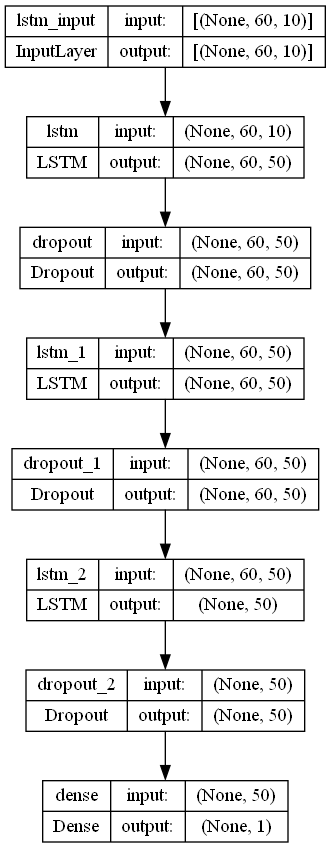

In [26]:
from keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
